# 1. Load packages

In [1]:
from os.path import abspath
import sys
sys.path.append(abspath(".."))

from EDA.EDA import *
from DataProcessor.DataProcessor import *
%load_ext autoreload
%autoreload 2

# 2. Download data
- Dataset: [Titanic - Machine Learning from Disaster](https://www.kaggle.com/c/titanic)
- Download data from [here](https://www.kaggle.com/c/titanic/data) or use [`kaggle API`](https://github.com/Kaggle/kaggle-api) below

In [2]:
%%system

mkdir input
kaggle competitions download -c titanic -p input
unzip input/titanic.zip -d input

['Downloading titanic.zip to input',
 '',
 '  0%|          | 0.00/34.1k [00:00<?, ?B/s]',
 '100%|██████████| 34.1k/34.1k [00:00<00:00, 632kB/s]',
 '',
 'Archive:  input/titanic.zip',
 '  inflating: input/gender_submission.csv  ',
 '  inflating: input/test.csv          ',
 '  inflating: input/train.csv         ']

# 3. Explatory Data Analysis

In [3]:
PATH.update()  # see details in /util.util.py
data_train = pd.read_csv(join(PATH.INPUT, 'train.csv'))
data_test  = pd.read_csv(join(PATH.INPUT, 'test.csv'))
data       = pd.concat([data_train, data_test])
data.set_index('PassengerId', inplace=True)
target_feature = 'Survived'

X, y = data.drop(columns=target_feature), data[target_feature]

In [4]:
eda = EDA(data, target=target_feature, save_path=PATH.RESULT)

# Full data(1309, 11): train(891, 11) + test(418, 11)

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
dtype,float64,int64,object,object,float64,int64,int64,object,float64,object,object
type,num,num,nom,nom,num,num,num,nom,num,nom,nom


In [5]:
ordinal_features = ['Pclass', 'SibSp', 'Parch']
nominal_features = ['Survived', 'Name', 'Sex', 'Ticket', 'Cabin', 'Embarked']
eda.set_types(ord=ordinal_features, nom=nominal_features)

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
dtype,object,object,object,object,float64,object,object,object,float64,object,object
type,nom,ord,nom,nom,num,ord,ord,nom,num,nom,nom


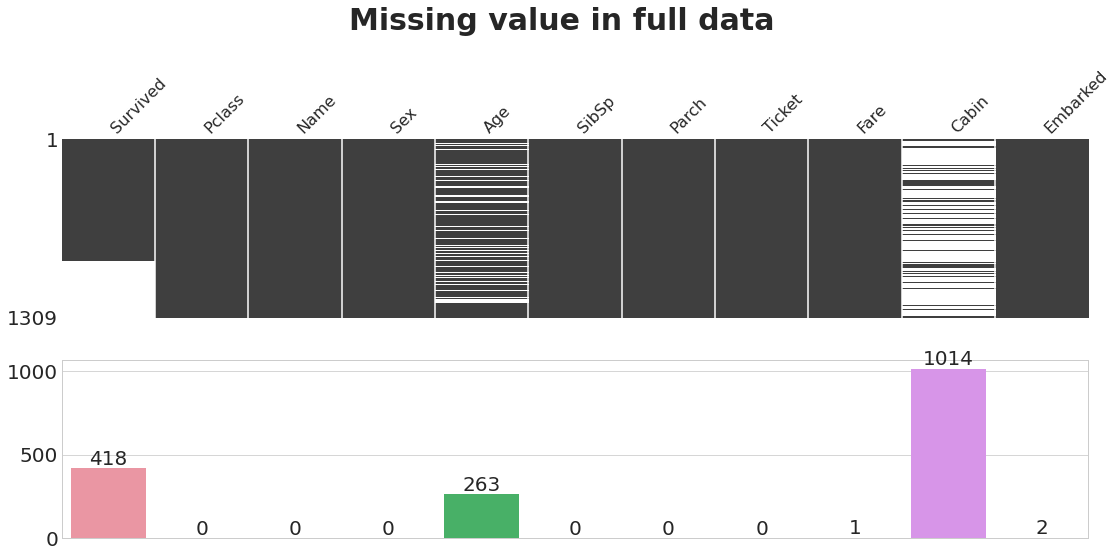

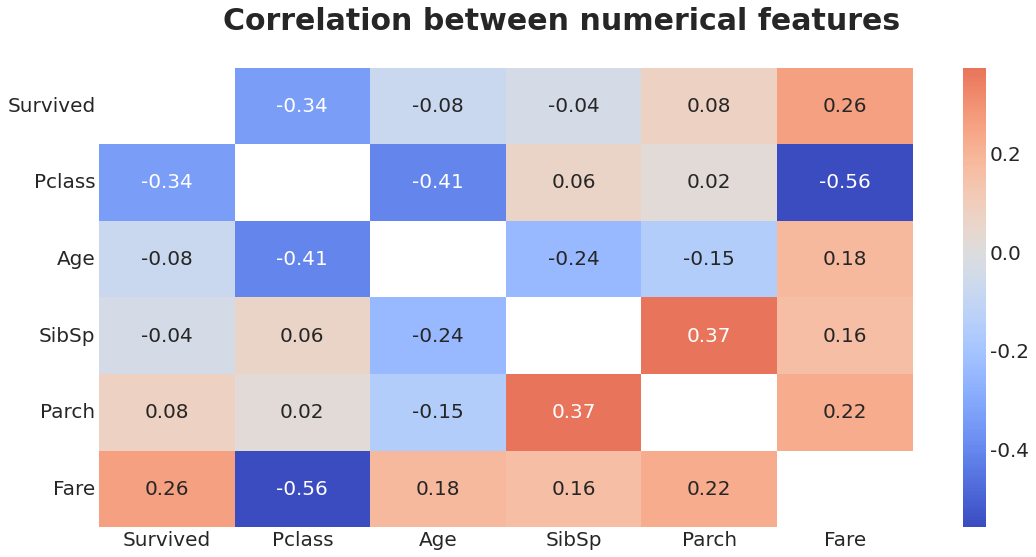

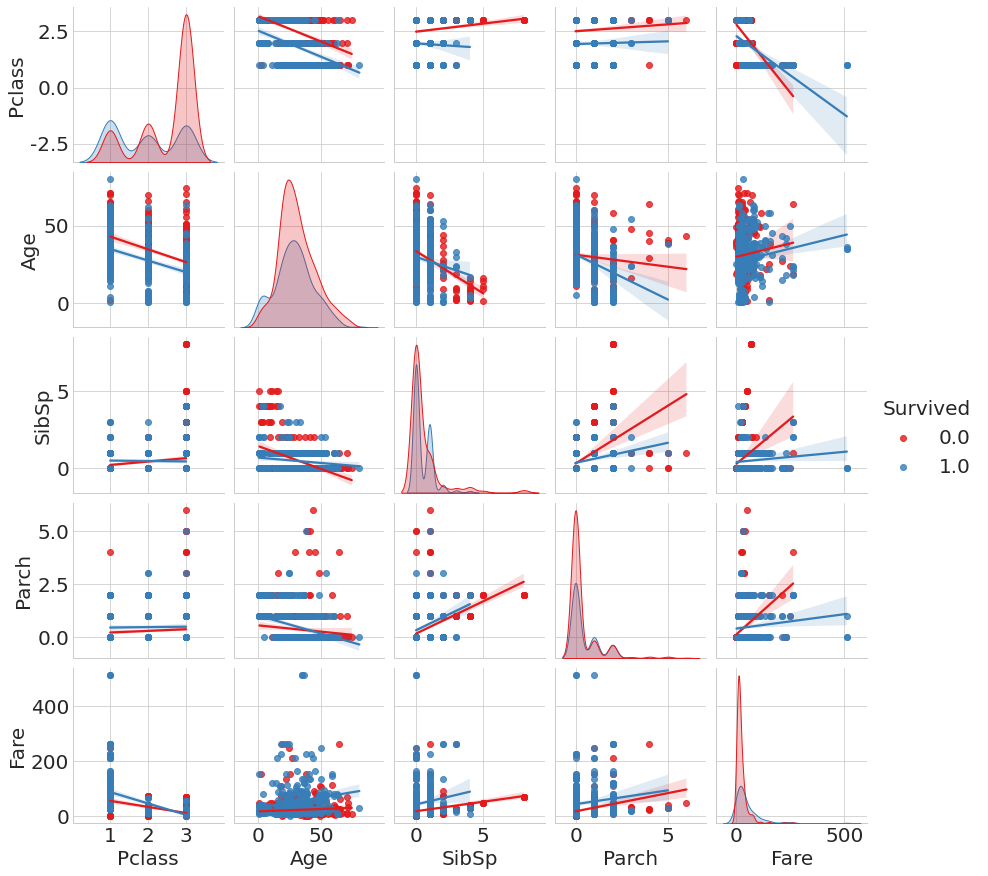

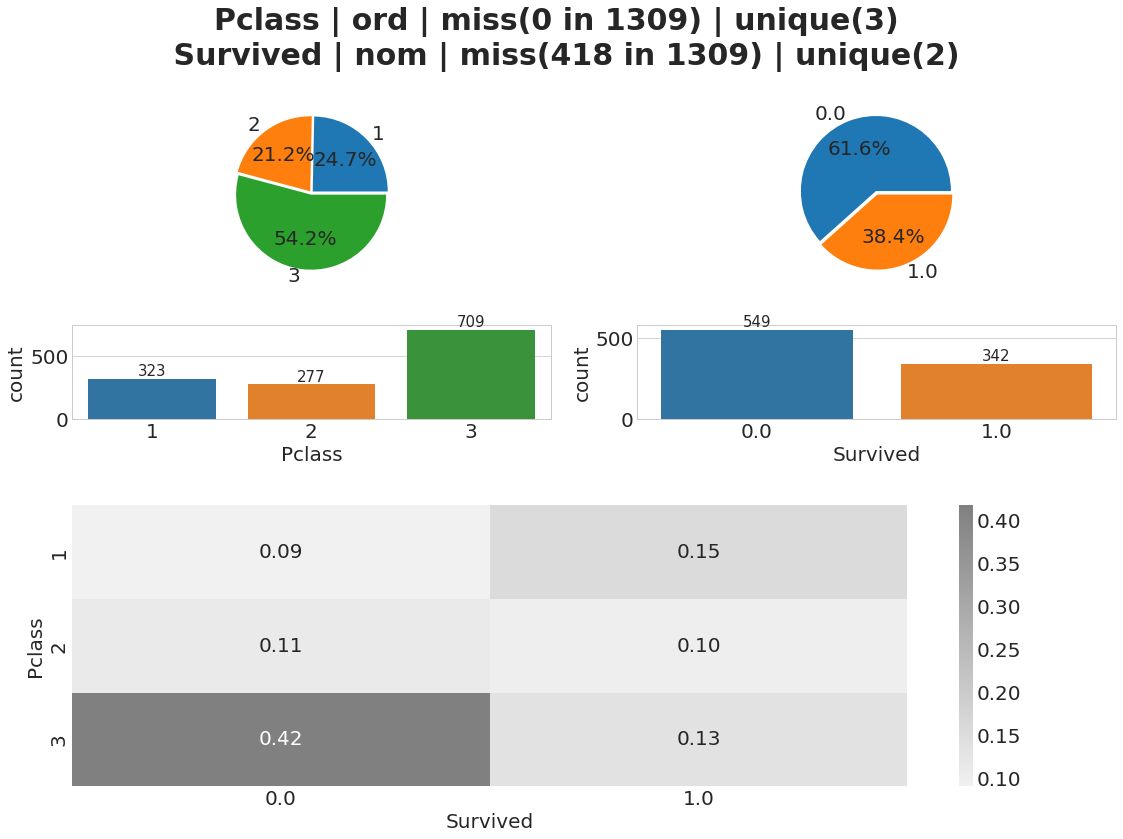

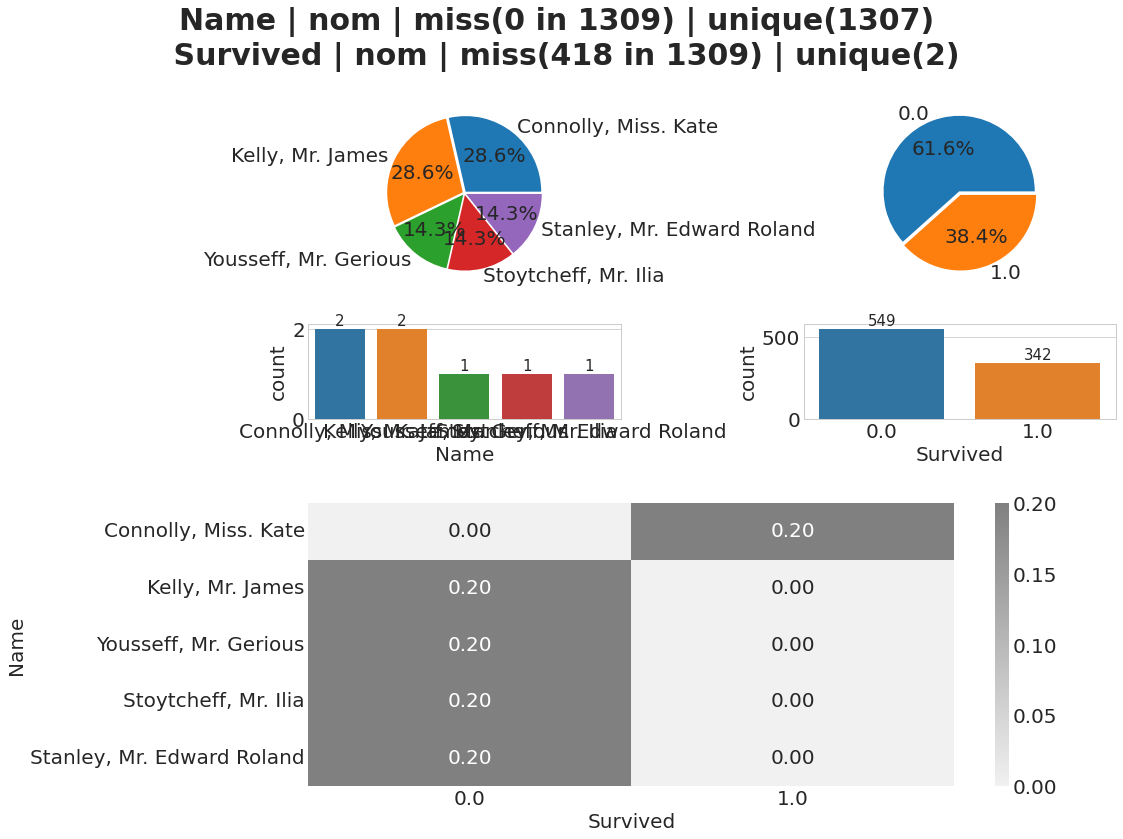

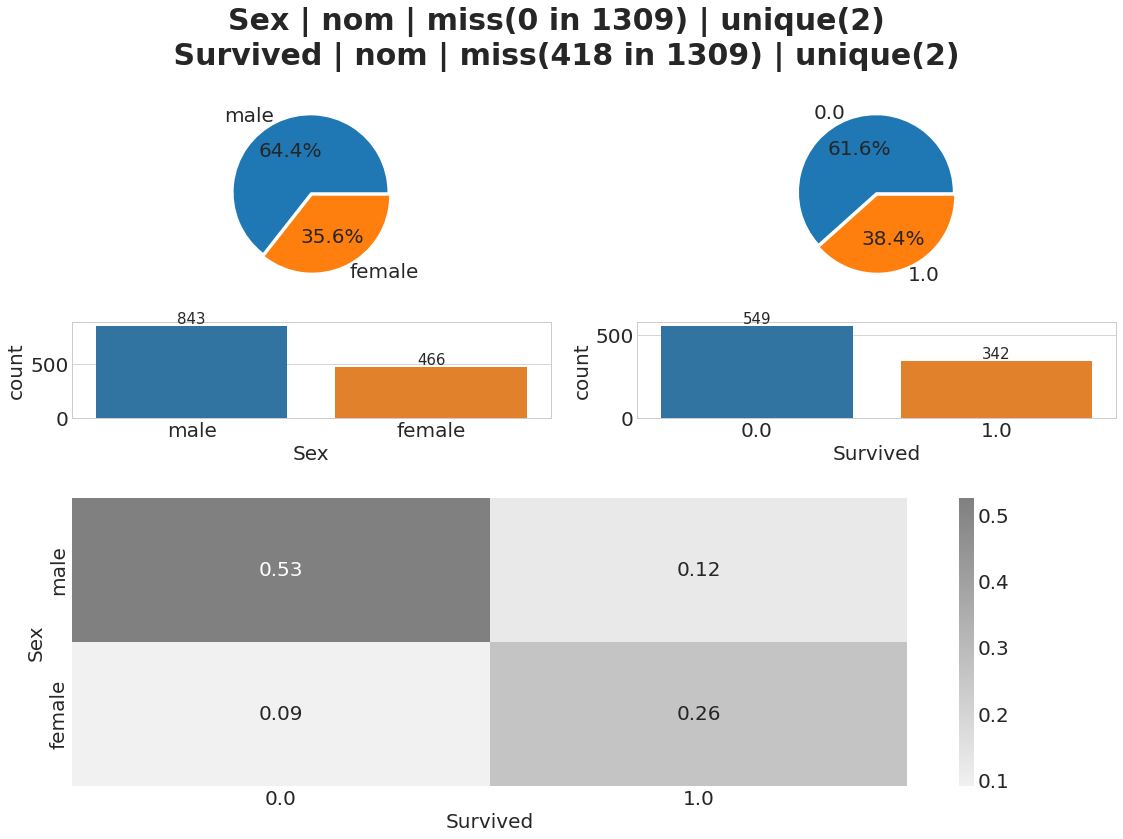

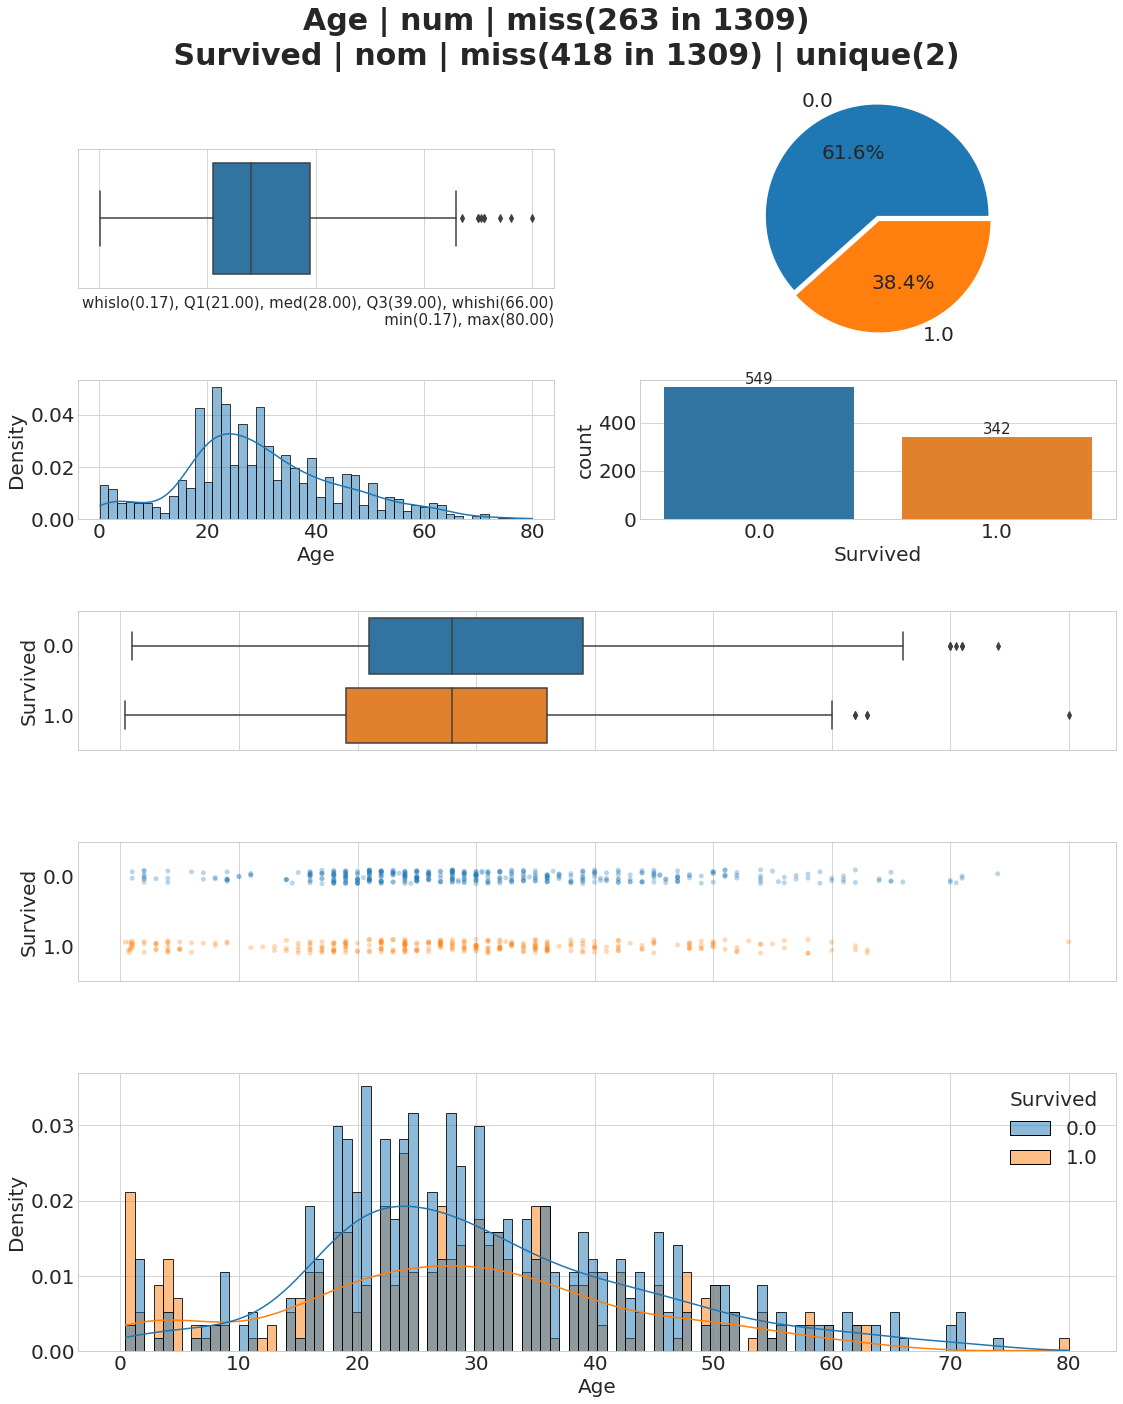

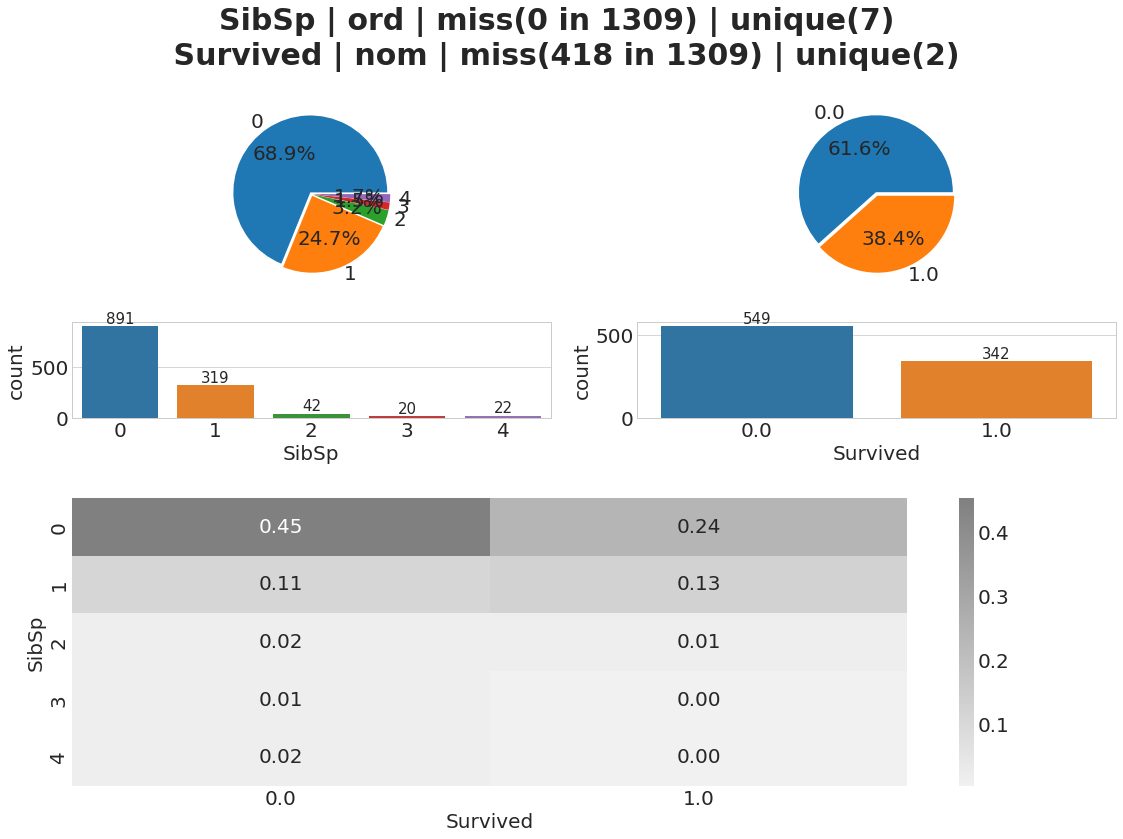

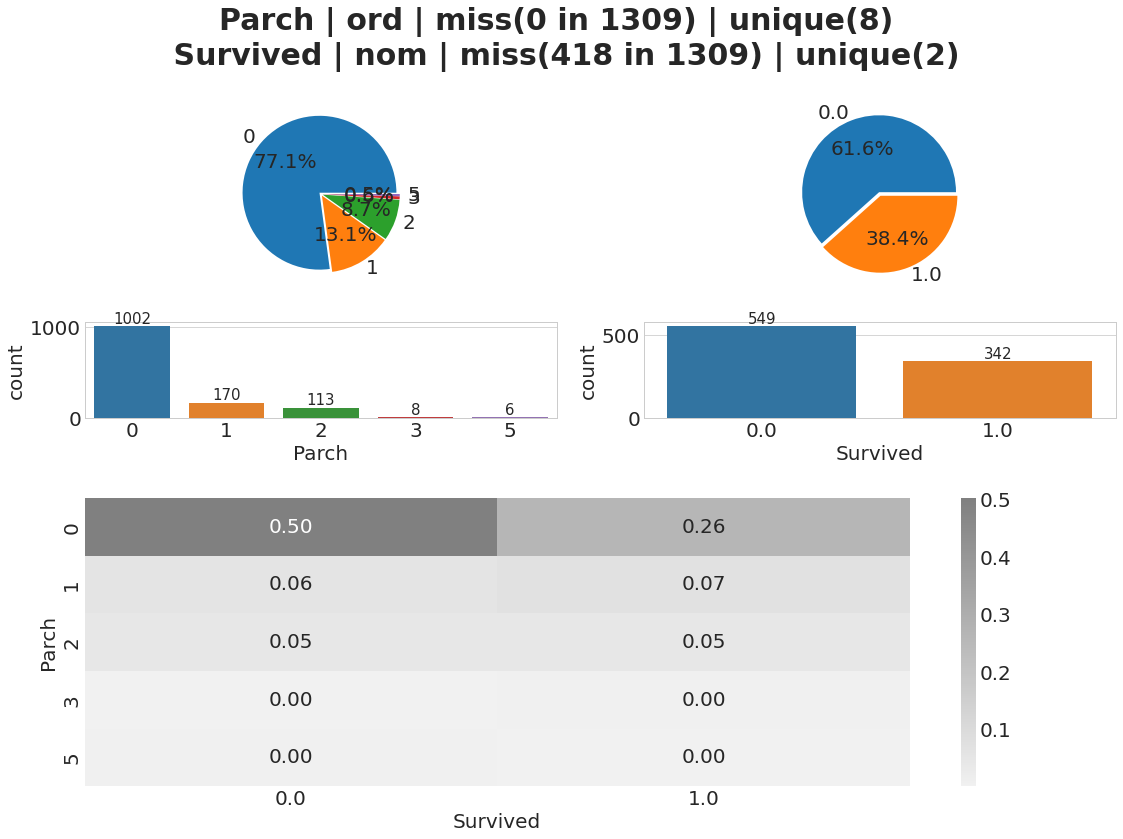

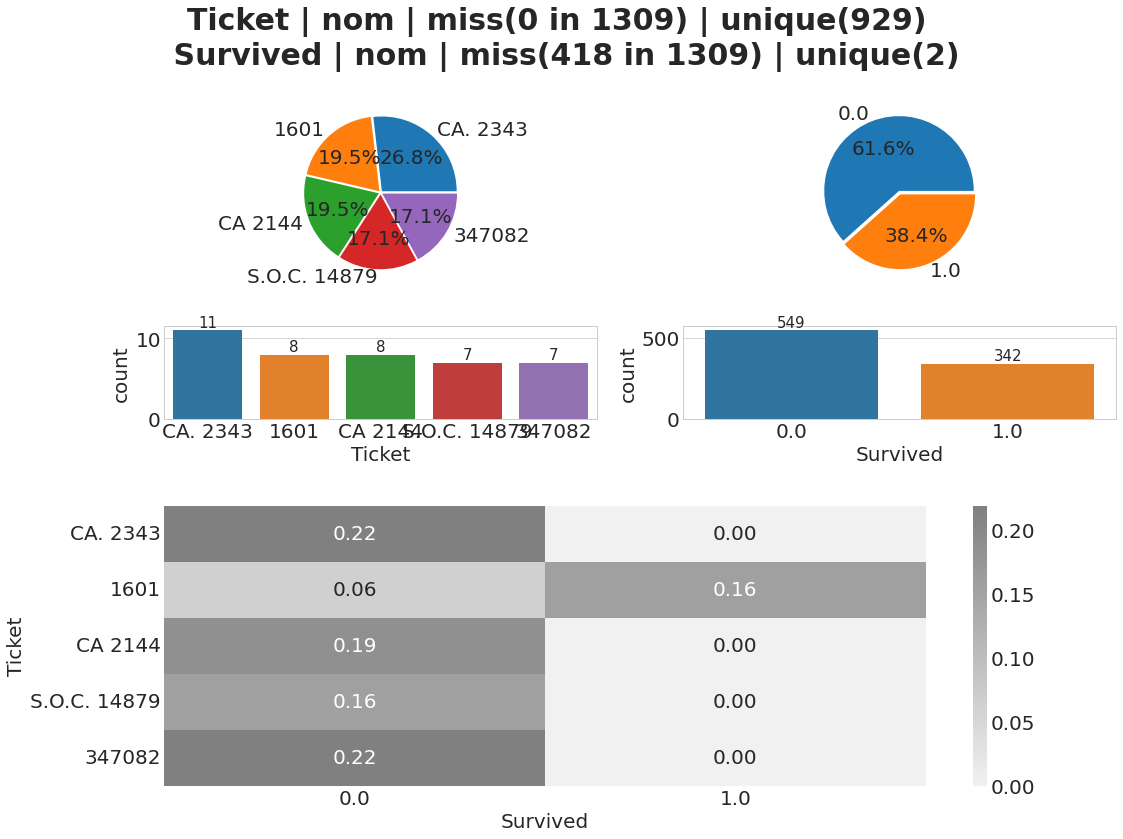

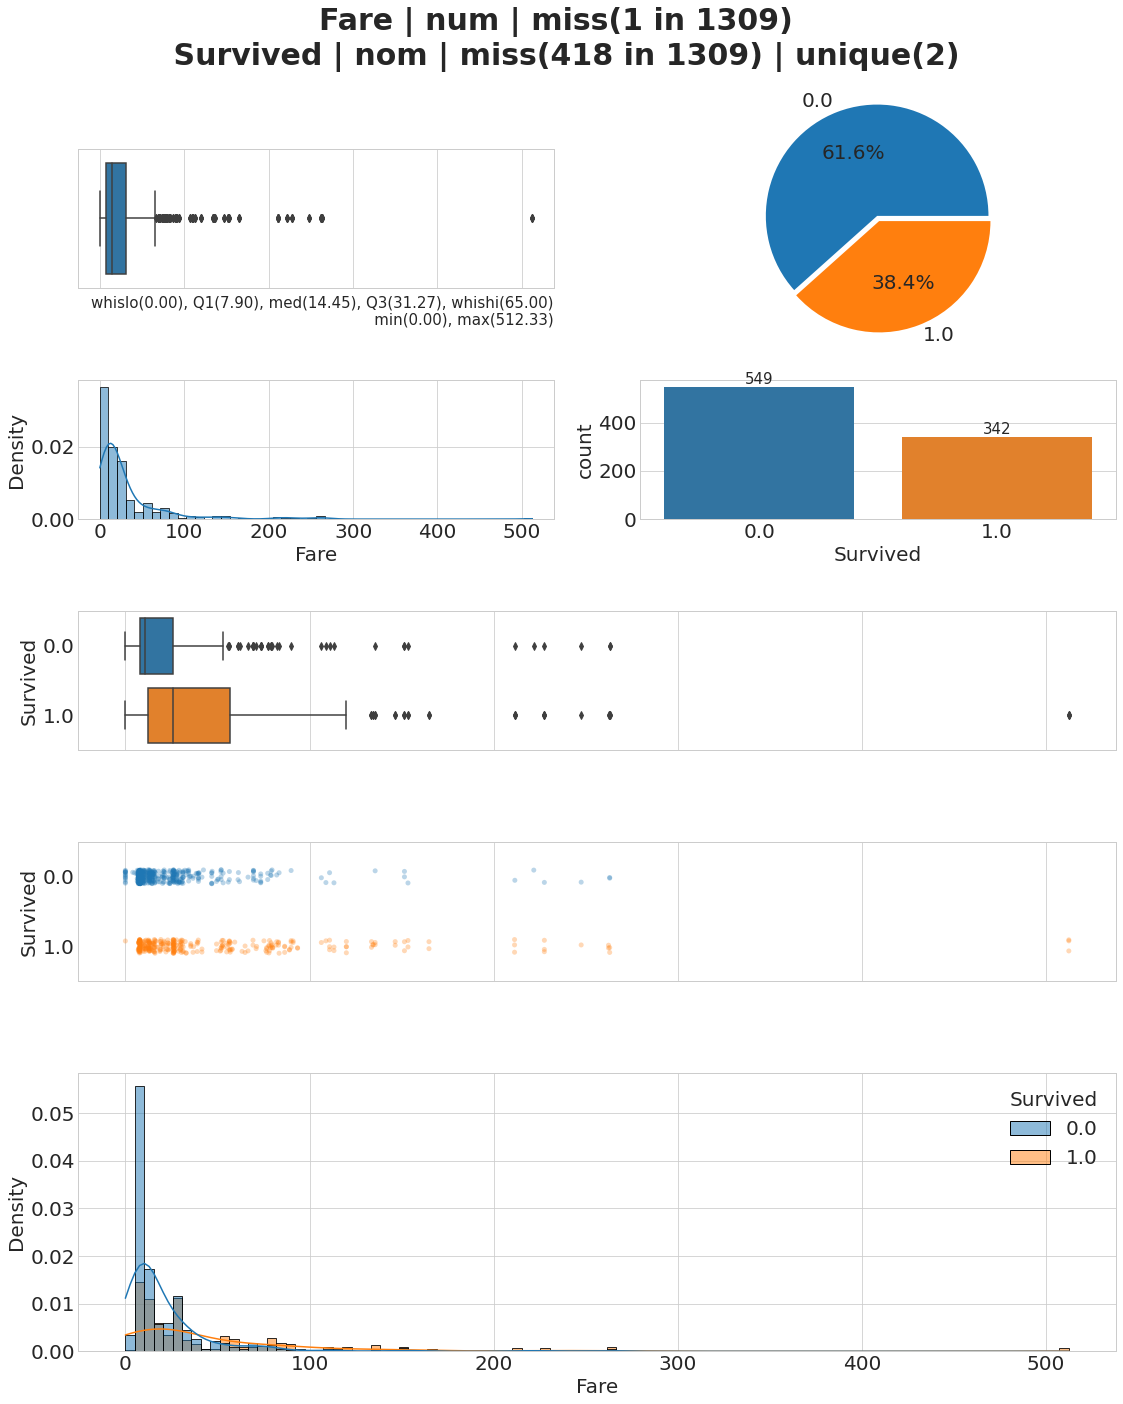

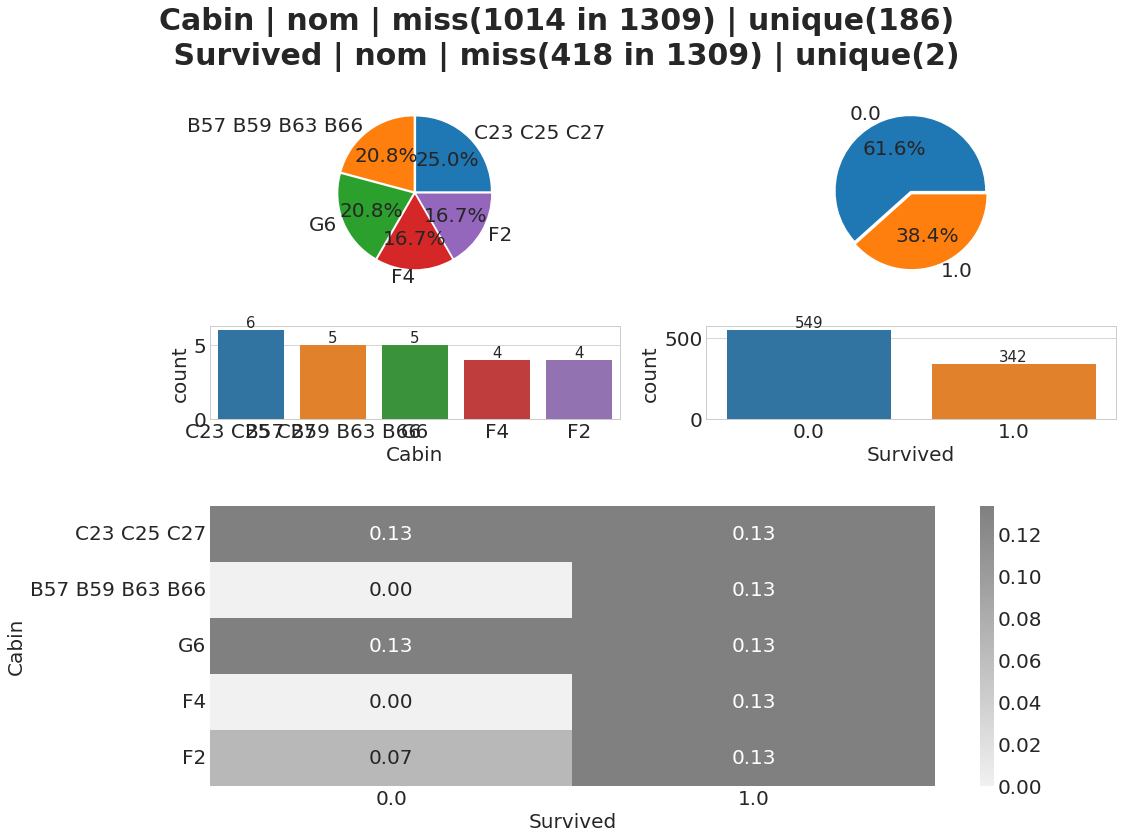

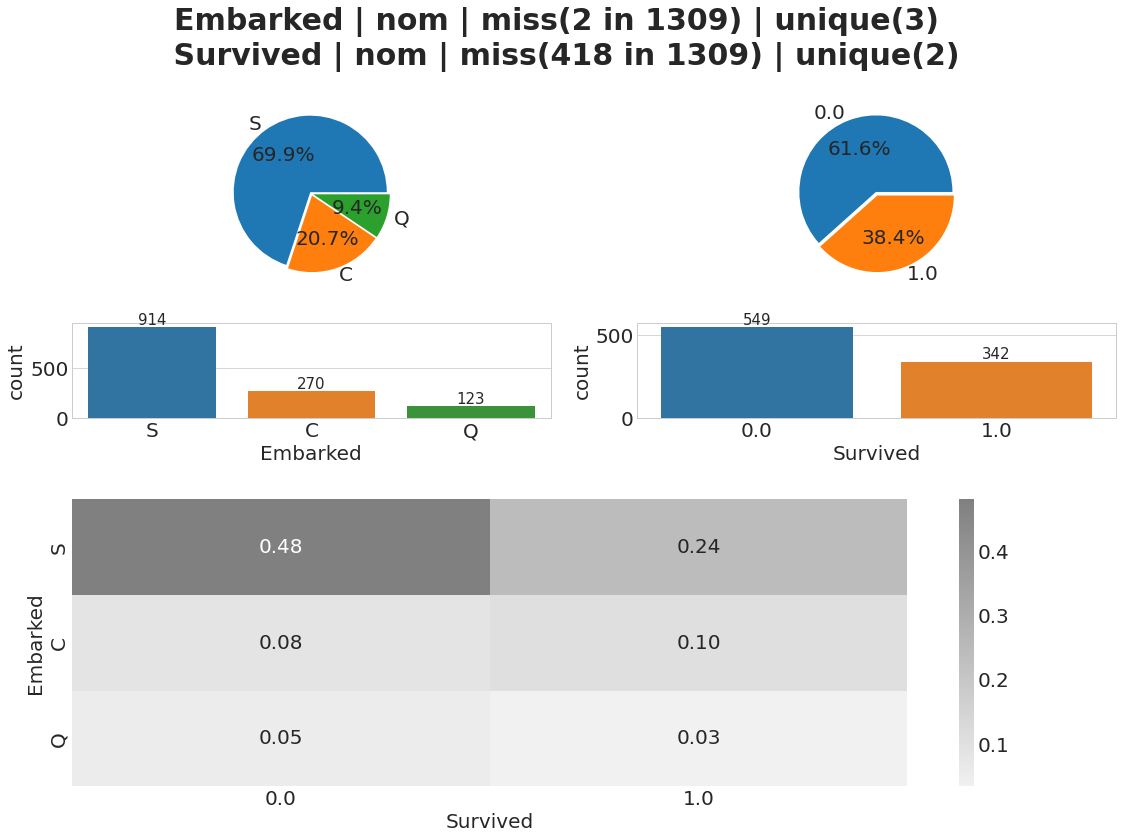

In [6]:
eda.run()

# 4. Feature engineering
- Select most important features using [Random Forest, Permutation importance](https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html)

In [7]:
processor   = DataProcessor(X, y)
train, test = processor.preprocess(ordinal_features, nominal_features)

X_train, y_train    = train['X'], train['y']
X_test, y_test_pred = test['X'], test['y']

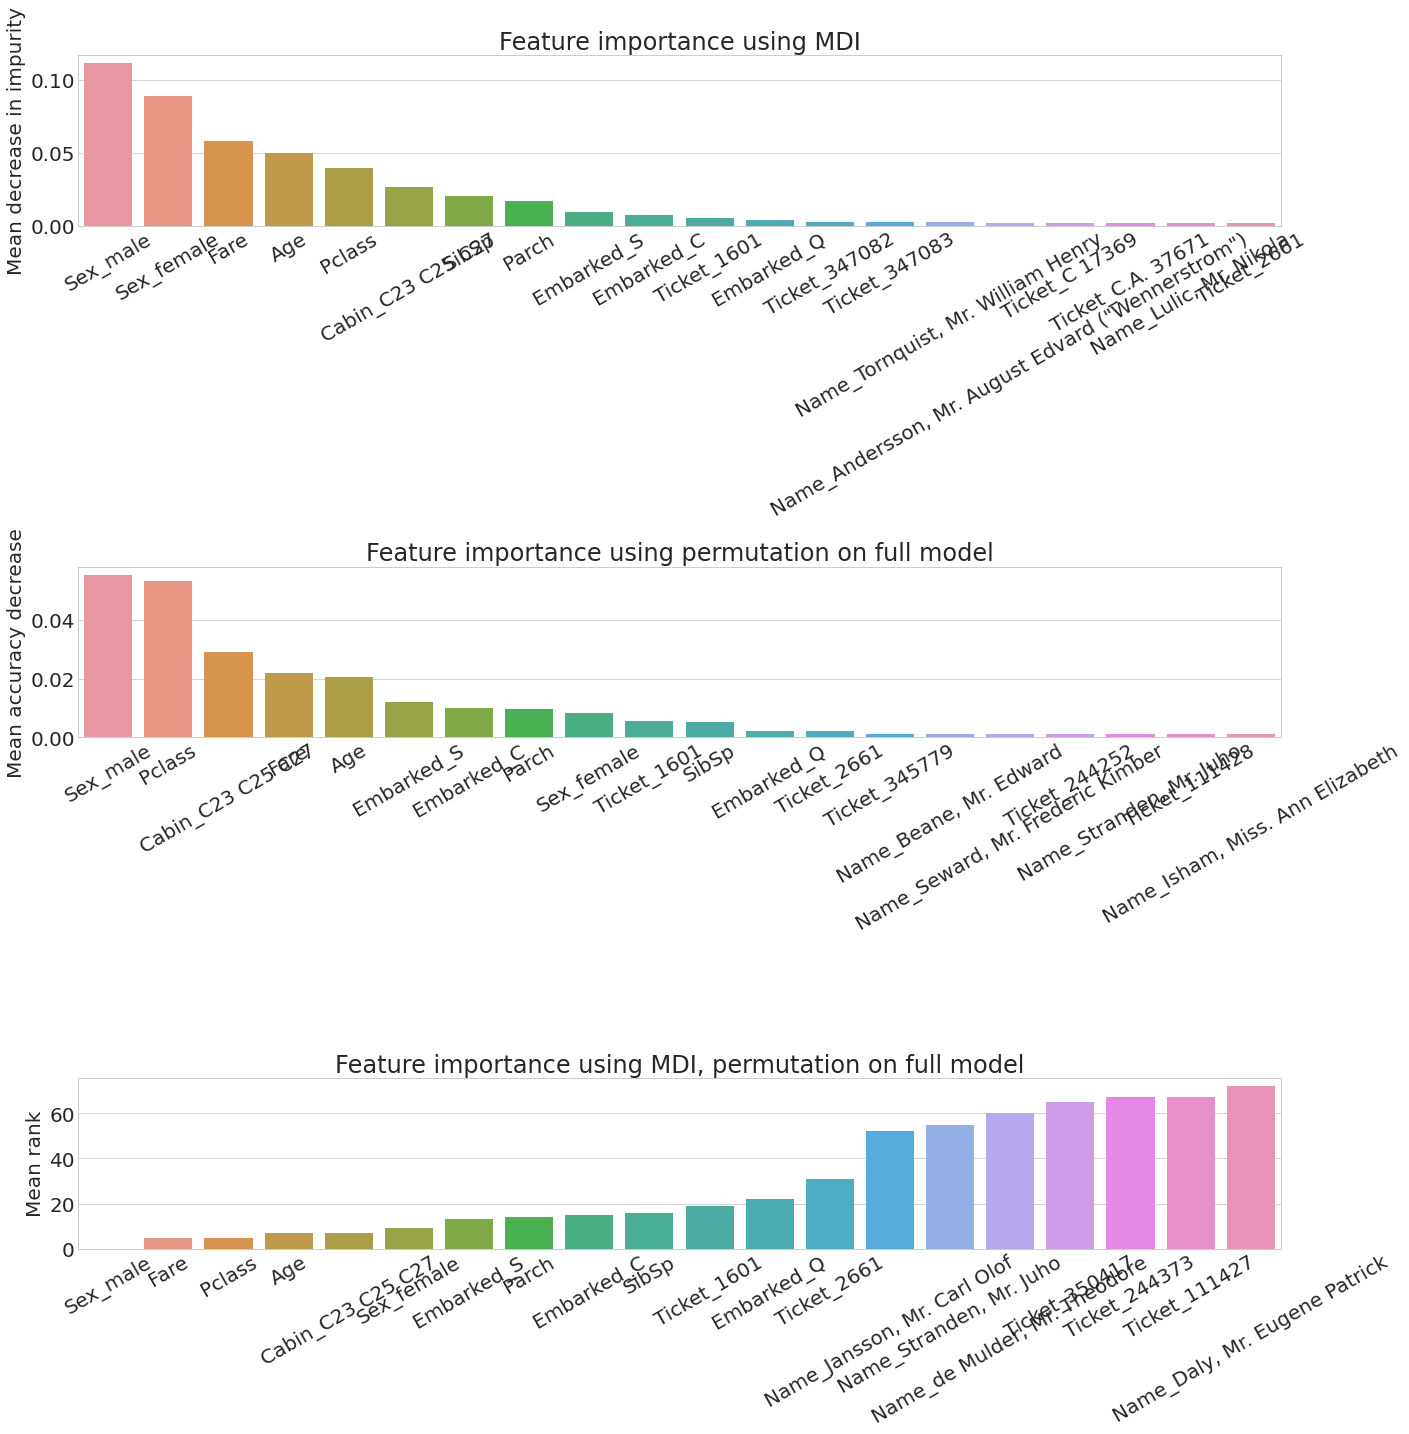

In [8]:
importances = eda.get_feature_importance(X_train, y_train)

In [9]:
n_selected_features = 10
selected_features   = importances[:n_selected_features].index
X_train = X_train[selected_features]
X_test  = X_test[selected_features]

# 5. Modeling
- Use RandomForest

In [10]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

model = RandomForestClassifier()
model.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
accuracy_score(y_train, y_train_pred)

0.9831649831649831

# 6. Submission
- Save `csv` file then submit to [here](https://www.kaggle.com/c/titanic/submissions) or use [`kaggle API`](https://github.com/Kaggle/kaggle-api) below

In [11]:
y_test_pred.loc[:] = model.predict(X_test)

sample_submission  = pd.read_csv(join(PATH.INPUT, 'gender_submission.csv'), index_col=0)
y_test_pred        = y_test_pred.astype(sample_submission.dtypes)

os.makedirs(join(PATH.OUTPUT))
y_test_pred.to_csv(join(PATH.OUTPUT, 'sample_submission.csv'))

In [12]:
%%system

kaggle competitions submit -c titanic -f output/sample_submission.csv -m "Sample submission"

['',
 '  0%|          | 0.00/2.77k [00:00<?, ?B/s]',
 '100%|██████████| 2.77k/2.77k [00:00<00:00, 20.4kB/s]',
 '100%|██████████| 2.77k/2.77k [00:02<00:00, 992B/s]  ',
 'Successfully submitted to Titanic - Machine Learning from Disaster']